In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline
import scipy as sc
from scipy import io
from IPython import display
import time

from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

from nonlinearities import *
from pls import *


np.random.seed(42)

In [2]:
NONPARAMETRICAL_TRANSROMATIONS = ['linear', 'p2', 'p3', 'p4', 's2', 's3', 's4']


def mse(Y_test, Y_pred):
    return mean_squared_error(Y_test, Y_pred)


def nmse(Y_test, Y_pred):
    return mean_squared_error(Y_test, Y_pred) / baseline(Y_test)


def baseline(Y_test):
     return mse(Y_test, np.tile(Y_test.mean(axis=0), (len(Y_test), 1)))

## Electroenergy

In [69]:
X = sc.io.loadmat('./../data/dataX.mat')['arr']
Y = sc.io.loadmat('./../data/dataY.mat')['arr']
# some daily information (5 weeks)
X = X[:-8, :-35]
Y = Y[8:, :-5]

train_size = 700

X_train, X_test = X[:train_size, :], X[train_size:, :]
Y_train, Y_test = Y[:train_size, :], Y[train_size:, :]

In [70]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((700, 168), (700, 24), (381, 168), (381, 24))

In [71]:
np.random.seed(42)
pls = PLSNonLinear(n_components=5, x_kind='linear', y_kind='linear')
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)
print(nmse(Y_train, pls.predict(X_train)))
print(nmse(Y_test, Y_pred))

0.0952924875402
0.115484510883


In [76]:
mse_n_comps = []

for k in np.arange(1, 25):
    pls = PLSNonLinear(n_components=k, x_kind='linear', y_kind='linear')
    pls.fit(X_train, Y_train)
    Y_pred = pls.predict(X_test)
    mse_n_comps.append(nmse(Y_test, Y_pred))
    display.clear_output(wait=True)
    print('Iteration {} is over'.format(k))
    
mse_n_comps = np.array(mse_n_comps)

Iteration 24 is over


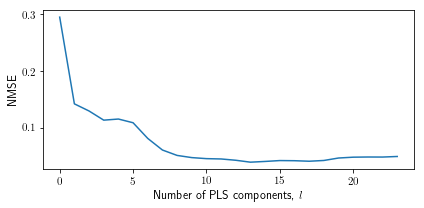

In [106]:
plt.figure(figsize=(6, 3))
plt.plot(np.arange(1, 25), mse_n_comps)
plt.xlabel('Number of PLS components, $l$', fontsize=12)
plt.ylabel('NMSE', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks([0.1, 0.2, 0.3], fontsize=11)

plt.tight_layout()
plt.savefig('figs/energy_n_comp.eps', format='eps')
plt.show()

In [89]:
n_comp = mse_n_comps.argmin() + 1
n_comp

14

In [90]:
pls = PLSNonLinear(n_components=n_comp, x_kind='linear', y_kind='linear')
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)

ts_test = Y_test.ravel()
ts_pred = Y_pred.ravel()

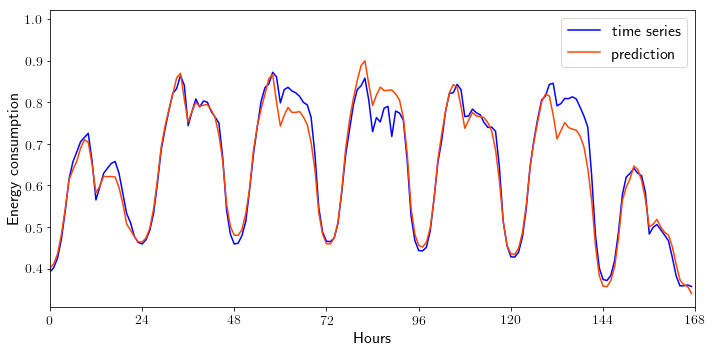

In [108]:
test = ts_test[20:20 + 24 * 7]
pred = ts_pred[20:20 + 24 * 7]

plt.figure(figsize=(10, 5))
plt.plot(test, label='time series', c='blue')
plt.plot(pred, label='prediction', c='orangered')

plt.legend(fontsize=16)
plt.ylim([test.min() - 0.05, test.max() + 0.15])
plt.xlim([0, 168])
plt.xticks([24 * i for i in range(8)], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Hours', fontsize=16)
plt.ylabel('Energy consumption', fontsize=16)
plt.tight_layout()
plt.savefig('figs/energy_prediction.eps', format='eps')
plt.show()

## ECoG

In [3]:
X_train_ecog = sc.io.loadmat('./../data/ECoG_X_train.mat')['X_train'].reshape([-1, 32 * 27])
Y_train_ecog = sc.io.loadmat('./../data/ECoG_Y_train.mat')['Y_train']

X_test_ecog = sc.io.loadmat('./../data/ECoG_X_test.mat')['X_hold_out'].reshape([-1, 32 * 27])
Y_test_ecog = sc.io.loadmat('./../data/ECoG_Y_test.mat')['Y_hold_out']

print(X_train_ecog.shape, Y_train_ecog.shape)
print(X_test_ecog.shape, Y_test_ecog.shape)

x_autoreg_step = 18
y_autoreg_step = 10

(12801, 864) (12801, 3)
(6087, 864) (6087, 3)


In [4]:
sh = X_train_ecog.shape
X_train = np.zeros([sh[0] - x_autoreg_step - y_autoreg_step + 2, x_autoreg_step * sh[1]])
for i in range(len(X_train)):
    X_train[i] = X_train_ecog[i:i + x_autoreg_step].ravel()

sh = Y_train_ecog.shape
Y_train = np.zeros([sh[0] - x_autoreg_step - y_autoreg_step + 2, y_autoreg_step * sh[1]])
for i in range(len(Y_train)):
    Y_train[i] = Y_train_ecog[i + x_autoreg_step - 1:i + y_autoreg_step + x_autoreg_step - 1].ravel()

print(X_train.shape, Y_train.shape)

sh = X_test_ecog.shape
X_test = np.zeros([sh[0] - x_autoreg_step - y_autoreg_step + 2, x_autoreg_step * sh[1]])
for i in range(len(X_test)):
    X_test[i] = X_test_ecog[i:i + x_autoreg_step].ravel()

sh = Y_test_ecog.shape
Y_test = np.zeros([sh[0] - x_autoreg_step - y_autoreg_step + 2, y_autoreg_step * sh[1]])
for i in range(len(Y_test)):
    Y_test[i] = Y_test_ecog[i + x_autoreg_step - 1:i + y_autoreg_step + x_autoreg_step - 1].ravel()

print(X_test.shape, Y_test.shape)


(12785, 6912) (12785, 30)
(6071, 6912) (6071, 30)


In [111]:
pls = PLSNonLinear(n_components=10)
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)
print(mse(Y_test, Y_pred))
print(nmse(Y_test, Y_pred))

1529.3529759
0.815738094129


In [113]:
mse_n_comps = []

for k in np.arange(1, 21):
    pls = PLSNonLinear(n_components=k, x_kind='linear', y_kind='linear')
    pls.fit(X_train, Y_train)
    Y_pred = pls.predict(X_test)
    mse_n_comps.append(nmse(Y_test, Y_pred))
    display.clear_output(wait=True)
    print('Iteration {} is over'.format(k))
    
mse_n_comps = np.array(mse_n_comps)

Iteration 20 is over


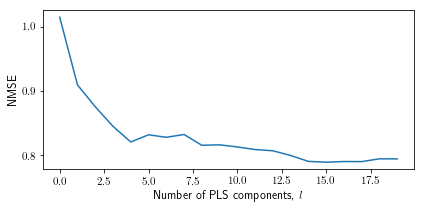

In [117]:
plt.figure(figsize=(6, 3))
plt.plot(mse_n_comps)
plt.xlabel('Number of PLS components, $l$', fontsize=12)
plt.ylabel('NMSE', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks([0.8, 0.9, 1.], fontsize=11)

plt.tight_layout()
plt.savefig('figs/ecog_n_comp.eps', format='eps')
plt.show()

In [115]:
n_comp = mse_n_comps.argmin() + 1
n_comp

16

In [119]:
pls = PLSNonLinear(n_components=n_comp)
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)

ts_pred = np.zeros([len(Y_test) - y_autoreg_step + 1, 3])
ts_test = np.zeros([len(Y_test) - y_autoreg_step + 1, 3])

for i in range(len(ts_pred)):
    ts_pred[i, 0] = np.mean([Y_pred[i + y_autoreg_step - 1 - k, 3 * k] 
                             for k in range(y_autoreg_step)])
    ts_pred[i, 1] = np.mean([Y_pred[i + y_autoreg_step - 1 - k, 3 * k + 1] 
                             for k in range(y_autoreg_step)])
    ts_pred[i, 2] = np.mean([Y_pred[i + y_autoreg_step - 1 - k, 3 * k + 2] 
                             for k in range(y_autoreg_step)])

ts_test = Y_test[:-y_autoreg_step + 1, -3:]

print(ts_pred.shape, ts_test.shape)

(6055, 3) (6055, 3)


In [ ]:
test = ts_test[:1000]
pred = ts_pred[:1000]

plt.figure(figsize=(10, 6))
plt.plot(test[:, 0], label='$x$-axis true', c='r')
plt.plot(pred[:, 0], label='$x$-axis pred', linestyle='--', c='r')
plt.plot(test[:, 1], label='$y$-axis true', c='g')
plt.plot(pred[:, 1], label='$y$-axis pred', linestyle='--', c='g')
plt.plot(test[:, 2], label='$z$-axis true', c='b')
plt.plot(pred[:, 2], label='$z$-axis pred', linestyle='--', c='b')
lgd = plt.legend(fontsize=16, bbox_to_anchor=(0.17, 0.85, 1., .102), loc=3, borderaxespad=0., ncol=3)
plt.ylim([test.min() - 50, test.max() + 100])
#plt.xlim([0, 144])
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Wrist coordinates', fontsize=16)
plt.xlabel('Time, ms', fontsize=16)
plt.tight_layout()
plt.savefig('figs/ecog_prediction.eps', format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

x_autoreg_step=18, y_autoreg_step=12, NMSE=0.73354


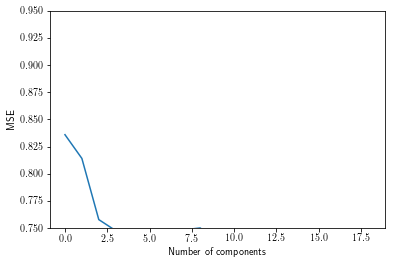

In [35]:
results = []
for x_autoreg_step in range(18, 19, 2):
    results.append([])
    for y_autoreg_step in range(12, 13, 2):
        sh = X_train_ecog.shape
        X_train = np.zeros([sh[0] - x_autoreg_step - y_autoreg_step + 2, x_autoreg_step * sh[1]])
        for i in range(len(X_train)):
            X_train[i] = X_train_ecog[i:i + x_autoreg_step].ravel()

        sh = Y_train_ecog.shape
        Y_train = np.zeros([sh[0] - x_autoreg_step - y_autoreg_step + 2, y_autoreg_step * sh[1]])
        for i in range(len(Y_train)):
            Y_train[i] = Y_train_ecog[i + x_autoreg_step - 1:i + y_autoreg_step + x_autoreg_step - 1].ravel()

        sh = X_test_ecog.shape
        X_test = np.zeros([sh[0] - x_autoreg_step - y_autoreg_step + 2, x_autoreg_step * sh[1]])
        for i in range(len(X_test)):
            X_test[i] = X_test_ecog[i:i + x_autoreg_step].ravel()

        sh = Y_test_ecog.shape
        Y_test = np.zeros([sh[0] - x_autoreg_step - y_autoreg_step + 2, y_autoreg_step * sh[1]])
        for i in range(len(Y_test)):
            Y_test[i] = Y_test_ecog[i + x_autoreg_step - 1:i + y_autoreg_step + x_autoreg_step - 1].ravel()

        mse_n_comps = []

        for n_comp in np.arange(2, 21):
            pls = PLSNonLinear(n_components=n_comp, x_kind='linear', y_kind='linear')
            pls.fit(X_train, Y_train)
            Y_pred = pls.predict(X_test)
            
            ts_pred = np.zeros([len(Y_test) - y_autoreg_step + 1, 3])
            ts_test = np.zeros([len(Y_test) - y_autoreg_step + 1, 3])

            for i in range(len(ts_pred)):
                ts_pred[i, 0] = np.mean([Y_pred[i + y_autoreg_step - 1 - k, 3 * k] 
                                         for k in range(y_autoreg_step)])
                ts_pred[i, 1] = np.mean([Y_pred[i + y_autoreg_step - 1 - k, 3 * k + 1] 
                                         for k in range(y_autoreg_step)])
                ts_pred[i, 2] = np.mean([Y_pred[i + y_autoreg_step - 1 - k, 3 * k + 2] 
                                         for k in range(y_autoreg_step)])

            ts_test = Y_test[:-y_autoreg_step + 1, -3:]    
            mse_n_comps.append(nmse(ts_test, ts_pred))
            display.clear_output(wait=True)
            print(nmse(ts_test, ts_pred))
            print('Iteration {} is over'.format(n_comp))

        mse_n_comps = np.array(mse_n_comps)
        results[-1].append(mse_n_comps)

        plt.figure(figsize=(6, 4))
        plt.plot(mse_n_comps)
        plt.xlabel('Number of components')
        plt.ylabel('MSE')
        plt.ylim([0.75, 0.95])
        plt.savefig('figs/x_autoreg_step={}_y_autoreg_step={}.eps'.format(x_autoreg_step, 
                                                                          y_autoreg_step), format='eps')
        display.clear_output(wait=True)
        print('x_autoreg_step={}, y_autoreg_step={}, NMSE={:.5f}'.format(x_autoreg_step, 
                                                                         y_autoreg_step, 
                                                                         mse_n_comps[-1]))
# np.save('results.npy', np.array(results))

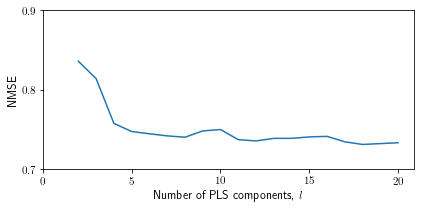

In [44]:
plt.figure(figsize=(6, 3))
plt.plot(np.arange(2, 21), mse_n_comps)
plt.xlabel('Number of PLS components, $l$', fontsize=12)
plt.ylabel('NMSE', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks([0.7, 0.8, 0.9], fontsize=11)
plt.xticks([0, 5, 10, 15, 20], fontsize=11)

plt.tight_layout()
plt.savefig('figs/ecog_n_comp.eps', format='eps')
plt.show()

In [39]:
n_comp = mse_n_comps.argmin() + 1
n_comp

17

In [16]:
results = np.load('results.npy')
for i in range(results.shape[0]):
    for j in range(results.shape[1]):
        print(i, j, ' '.join(['{:.3f}'.format(res) for res in results[i][j]]))

0 0 0.969 0.905 0.898 0.896 0.892 0.885 0.886 0.887 0.888
0 1 0.966 0.902 0.896 0.891 0.891 0.882 0.871 0.879 0.881
0 2 0.965 0.902 0.897 0.890 0.892 0.883 0.870 0.876 0.878
0 3 0.964 0.904 0.901 0.892 0.895 0.886 0.874 0.877 0.877
0 4 0.964 0.908 0.907 0.898 0.898 0.892 0.884 0.883 0.882
0 5 0.965 0.912 0.913 0.906 0.896 0.894 0.891 0.887 0.887
0 6 0.964 0.916 0.915 0.910 0.899 0.897 0.896 0.892 0.892
0 7 0.964 0.919 0.917 0.911 0.901 0.899 0.898 0.894 0.900
0 8 0.964 0.922 0.919 0.911 0.907 0.912 0.904 0.896 0.905
0 9 0.964 0.924 0.921 0.911 0.909 0.913 0.906 0.900 0.908
1 0 0.946 0.865 0.843 0.847 0.837 0.835 0.831 0.820 0.828
1 1 0.943 0.863 0.844 0.849 0.840 0.836 0.821 0.821 0.820
1 2 0.942 0.863 0.849 0.853 0.840 0.837 0.823 0.821 0.828
1 3 0.942 0.867 0.855 0.860 0.849 0.843 0.829 0.826 0.836
1 4 0.942 0.871 0.863 0.868 0.858 0.848 0.836 0.832 0.845
1 5 0.942 0.876 0.878 0.875 0.866 0.854 0.844 0.839 0.853
1 6 0.941 0.882 0.882 0.880 0.874 0.861 0.848 0.846 0.848
1 7 0.941 0.88

In [40]:
n_comp = mse_n_comps.argmin()
print(n_comp, mse_n_comps.min())

16 0.731378368539


In [41]:
pls = PLSNonLinear(n_components=17)
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)

ts_pred = np.zeros([len(Y_test) - y_autoreg_step + 1, 3])
ts_test = np.zeros([len(Y_test) - y_autoreg_step + 1, 3])

for i in range(len(ts_pred)):
    ts_pred[i, 0] = np.mean([Y_pred[i + y_autoreg_step - 1 - k, 3 * k] 
                             for k in range(y_autoreg_step)])
    ts_pred[i, 1] = np.mean([Y_pred[i + y_autoreg_step - 1 - k, 3 * k + 1] 
                             for k in range(y_autoreg_step)])
    ts_pred[i, 2] = np.mean([Y_pred[i + y_autoreg_step - 1 - k, 3 * k + 2] 
                             for k in range(y_autoreg_step)])

ts_test = Y_test[:-y_autoreg_step + 1, -3:] 
print(ts_pred.shape, ts_test.shape)

(6048, 3) (6048, 3)


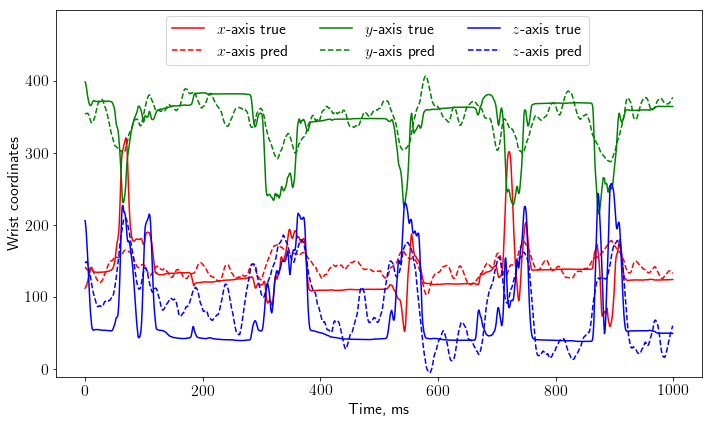

In [42]:
test = ts_test[:1000]
pred = ts_pred[:1000]

plt.figure(figsize=(10, 6))
plt.plot(test[:, 0], label='$x$-axis true', c='r')
plt.plot(pred[:, 0], label='$x$-axis pred', linestyle='--', c='r')
plt.plot(test[:, 1], label='$y$-axis true', c='g')
plt.plot(pred[:, 1], label='$y$-axis pred', linestyle='--', c='g')
plt.plot(test[:, 2], label='$z$-axis true', c='b')
plt.plot(pred[:, 2], label='$z$-axis pred', linestyle='--', c='b')
lgd = plt.legend(fontsize=16, bbox_to_anchor=(0.17, 0.85, 1., .102), loc=3, borderaxespad=0., ncol=3)
plt.ylim([test.min() - 50, test.max() + 100])
#plt.xlim([0, 144])
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Wrist coordinates', fontsize=16)
plt.xlabel('Time, ms', fontsize=16)
plt.tight_layout()
plt.savefig('figs/ecog_prediction.eps', format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [190]:
n_comp = np.array(mse_n_comps).argmin() + 1
n_comp

1

In [192]:
pls = PLSNonLinear(n_components=n_comp)
pls.fit(X_train_ecog, Y_train_ecog)
Y_pred_ecog = pls.predict(X_test_ecog)

print(mse(Y_test_ecog, Y_pred_ecog), nmse(Y_test_ecog, Y_pred_ecog))

1920.39301594 1.02649912329


In [5]:
results_ecog = {}
BASELINE_ECOG = baseline(Y_test_ecog)

for x_transform in NONPARAMETRICAL_TRANSROMATIONS:
    for y_transform in ['linear']:
        mse_n_comps = []
        for n_comp in [1, 5, 10, 15, 20]:
            pls = PLSNonLinear(n_components=n_comp, 
                               x_kind=x_transform, 
                               y_kind=y_transform)
            pls.fit(X_train_ecog, Y_train_ecog)
            Y_pred_ecog = pls.predict(X_test_ecog)
            mse_n_comps.append(mse(Y_test_ecog, Y_pred_ecog))
        mse_n_comps = np.array(mse_n_comps)
        best_mse = mse_n_comps.min()
        results_ecog[x_transform + '-' + y_transform] = mse_n_comps
        display.clear_output(wait=True)
        print('-x_transform:', x_transform)
        print('-y_transform:', y_transform)
        print('-mse: {:.5f}'.format(best_mse))
        print('-nmse: {:.5f}'.format(best_mse / BASELINE_ECOG))

-x_transform: s4
-y_transform: linear
-mse: 1756.91911
-nmse: 0.93912


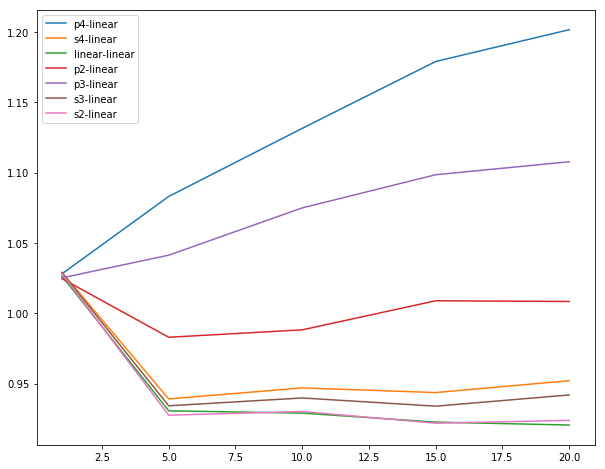

In [11]:
plt.figure(figsize=(10, 8))

for key, val in results_ecog.iteritems():
    plt.plot([1, 5, 10, 15, 20], val / BASELINE_ECOG, label=key)

plt.legend()
plt.show()

## Nonlinear transformations

In [42]:
def g1(x, a=0., b=1.):
    return np.sign(x) * np.exp(a) * (np.exp(b * np.abs(x)) - 1)


def g2(x, a=0.):
    return np.sign(x) * np.exp(a) * np.sqrt(np.abs(x))


def g3(x, a=0., b=1.):
    return np.sign(x) * np.exp(a) * (np.exp(b * np.sqrt(np.abs(x))) - 1)


def g4(x, a=0., b=1.):
    return np.sign(x) * np.exp(a) * (np.exp(b * np.abs(x) ** (1./3)) - 1)

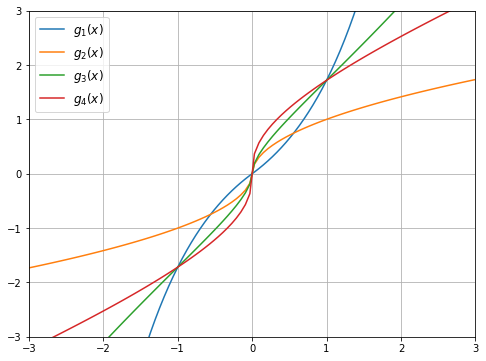

In [51]:
funcs_names = ['$g_1(x)$', '$g_2(x)$', '$g_3(x)$', '$g_4(x)$']
funcs = [g1, g2, g3, g4]
x = np.linspace(start=-3, stop=3, num=100)

plt.figure(figsize=(8, 6))
for f, name in zip(funcs, funcs_names):
    plt.plot(x, f(x), label=name)

plt.legend(fontsize=12)
plt.grid()
plt.xlim([-3., 3.])
plt.ylim([-3., 3.])
plt.show()

In [52]:
def ginv_1(y, a=0., b=1., tol=1e-9):
    return np.sign(y) * np.log(1 + np.abs(y) * np.exp(-a)) / (b + tol)


def ginv_2(y, a=0.):
    return np.sign(y) * (np.exp(-a) * y) ** 2


def ginv_3(y, a=0., b=1., tol=1e-9):
    return np.sign(y) * (np.log(1 + np.abs(y) * np.exp(-a)) / (b + tol)) ** 2


def ginv_4(y, a=0., b=1., tol=1e-9):
    return np.sign(y) * (np.log(1 + np.abs(y) * np.exp(-a)) / (b + tol)) ** 3

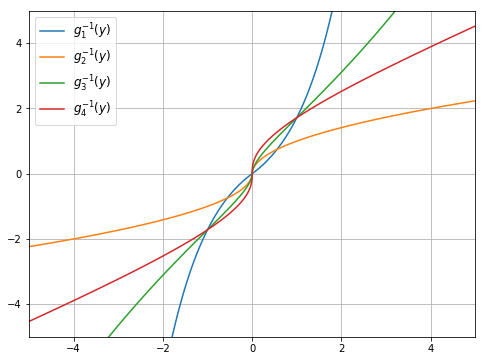

In [53]:
funcs_names = ['$g^{-1}_1(y)$', '$g^{-1}_2(y)$', '$g^{-1}_3(y)$', '$g^{-1}_4(y)$']
funcs = [ginv_1, ginv_2, ginv_3, ginv_4]
x = np.linspace(start=-5, stop=5, num=100)

plt.figure(figsize=(8, 6))
for f, name in zip(funcs, funcs_names):
    plt.plot(f(x), x, label=name)

plt.legend(fontsize=12)
plt.grid()
plt.xlim([-5., 5.])
plt.ylim([-5., 5.])
plt.show()

In [32]:
np.sqrt(np.mean((Y_test - Y_test.mean()) ** 2))

123.88404105191663

In [25]:

np.random.randn(2)

array([ 0.49671415, -0.1382643 ])